This code is to analyze the dynamics of learning across multiple runs with varying hidden state initializations and neuronal activations. It loads runs, computes and aggregates per-run metrics, plots and saves mean/std loss across runs, aggregates metrics timeseries and gradients.

In [4]:
from pathlib import Path
import pandas as pd
import sys
import pickle

sys.path.append("..")
import AggregateMultiruns as am
import PlotMultiruns as pm

In [20]:
# CONFIG
MODEL_ROOT = Path("../Elman_SGD/Remap_predloss/N100T100/")
HIDDEN_WEIGHT_INITS = [
    "he",
    "cyclic-shift",
    "shift",
    "cmh",
    "mh",
    "ctridiag",
    "tridiag",
    "orthog",
]
INPUT_TYPES = ["gaussian", "onehot", "khot", "small-gaussian"]
MULTIRUNS_DIR = "multiruns"
RUN_PREFIX = "run_"
MODEL_FNAME = "Ns100_SeqN100_predloss_full.pth.tar"
HIDDEN_WEIGHTS_SUBDIR = "hidden-weights"

# I/O dir for CSVs
CSV_ROOT = MODEL_ROOT / "RESULTS-10RUNS-09102025"

# Paths to results
per_run_csv = CSV_ROOT / "per_run_metrics.csv"
agg_csv = CSV_ROOT / "agg_metrics.csv"
ts_path = CSV_ROOT / "ts_bucket.pkl"

In [6]:
# per_run_df, agg_df, ts_bucket = am.collect_all(
#    h_inits=hidden_weights_inits[:1], in_types=input_types[:1]
# )

In [7]:
## Load all results from CSVs
# Per-run metrics (all settings, all runs)
per_run_all = pd.read_csv(CSV_ROOT / "per_run_metrics.csv")

# Aggregated metrics (one row per (hidden_init, input_type))
agg_all = pd.read_csv(CSV_ROOT / "agg_metrics.csv")

# Time-series bucket (dict of DataFrames, one per (hidden_init, input_type))
with open(CSV_ROOT / "ts_bucket.pkl", "rb") as f:
    ts_bucket = pickle.load(f)

In [11]:
display(per_run_all.head())
display(agg_all.head())
ts_bucket[("he", "gaussian")].keys()

,hidden_init,input_type,run_kind,run_id,path,final_loss,best_loss,best_epoch,loss_auc,time_to_110pct_best,...,act_mean_max,act_mean_min,act_std_mean,act_std_std,act_std_max,act_std_min,tanh_sat_mean,tanh_sat_std,tanh_sat_max,tanh_sat_min
0,he,gaussian,multirun,0,Elman_SGD/Remap_predloss/N100T100/he/gaussian/...,0.004792,0.004714,49999,1128.609213,44661,...,0.280204,0.192651,0.715800,0.098309,0.780552,0.375673,0.034780,0.029738,0.086465,0.0
1,he,gaussian,multirun,1,Elman_SGD/Remap_predloss/N100T100/he/gaussian/...,0.004791,0.004714,49999,1132.135982,44578,...,0.279791,0.178231,0.710201,0.098923,0.774416,0.372054,0.030602,0.025814,0.073030,0.0
2,he,gaussian,multirun,2,Elman_SGD/Remap_predloss/N100T100/he/gaussian/...,0.004918,0.004838,49999,1142.335403,44600,...,0.298651,0.194781,0.712490,0.096125,0.775007,0.375815,0.028634,0.022234,0.066566,0.0
3,he,gaussian,multirun,3,Elman_SGD/Remap_predloss/N100T100/he/gaussian/...,0.004754,0.004676,49999,1139.350711,44695,...,0.272924,0.191740,0.713767,0.103190,0.784248,0.362124,0.030022,0.024359,0.073131,0.0
4,he,gaussian,multirun,4,Elman_SGD/Remap_predloss/N100T100/he/gaussian/...,0.004744,0.004667,49999,1135.783564,44665,...,0.254524,0.174078,0.718687,0.099058,0.786054,0.368144,0.029192,0.021325,0.064545,0.0


,hidden_init,input_type,num_runs,final_loss_mean,final_loss_std,best_loss_mean,best_loss_std,best_epoch_mean,best_epoch_std,loss_auc_mean,...,act_std_min_mean,act_std_min_std,tanh_sat_mean_mean,tanh_sat_mean_std,tanh_sat_std_mean,tanh_sat_std_std,tanh_sat_max_mean,tanh_sat_max_std,tanh_sat_min_mean,tanh_sat_min_std
0,cmh,gaussian,10,0.006713,0.000684,0.006579,0.000671,49998.8,0.421637,1355.521151,...,0.938930,0.000169,0.701891,0.009704,0.005118,0.002318,0.712475,0.006529,0.694434,0.007401
1,cmh,khot,10,0.048567,0.000037,0.048557,0.000038,49999.0,0.000000,2596.969882,...,0.936308,0.000028,0.753678,0.010769,0.013711,0.003820,0.765950,0.014806,0.699596,0.001673
2,cmh,onehot,10,0.011397,0.000010,0.011376,0.000010,49999.0,0.000000,806.541603,...,0.932071,0.000101,0.738666,0.008181,0.013944,0.003783,0.752525,0.008133,0.692828,0.001547
3,cmh,small-gaussian,10,0.035873,0.000075,0.035863,0.000077,49999.0,0.000000,1956.268718,...,0.936679,0.000030,0.749622,0.010023,0.013159,0.003248,0.762101,0.013198,0.700222,0.001210
4,ctridiag,gaussian,10,0.025196,0.027183,0.021479,0.022629,46496.4,11076.193733,3044.833941,...,0.935109,0.013444,0.679827,0.147192,0.044219,0.044325,0.719909,0.155454,0.561899,0.075303


dict_keys(['losses', 'metrics_df_list', 'grad_df_list', 'history_df_list'])

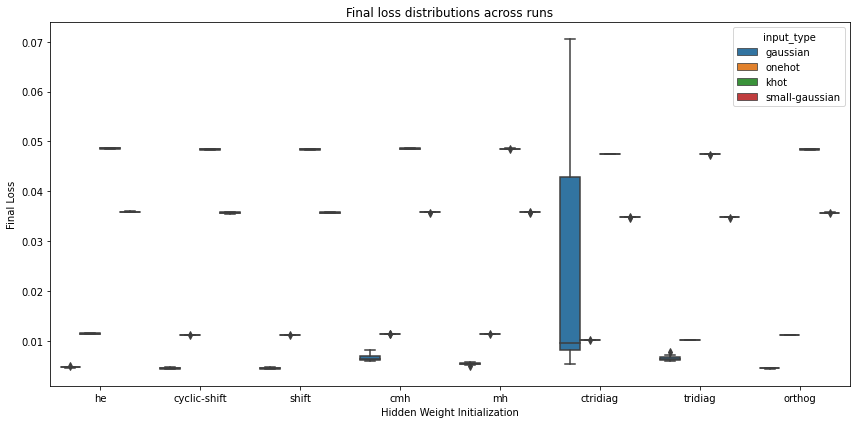

In [17]:
# 1) Final loss distributions
pm.plot_final_loss_boxplot(per_run_csv=per_run_csv)

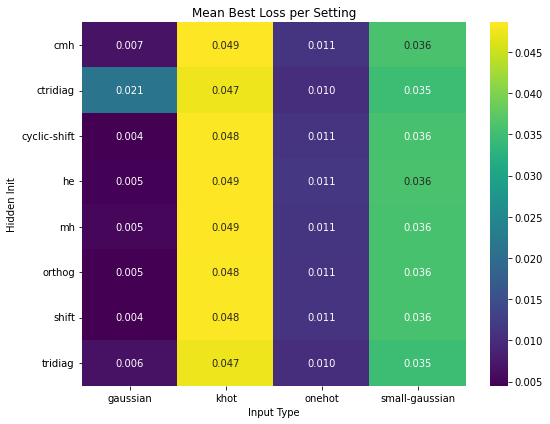

In [18]:
# 2) Heatmap of mean best loss
pm.plot_best_loss_heatmap(agg_csv=agg_csv)

In [21]:
# 3) Loss curves (mean ± std) for selected settings
pm.plot_loss_curves_mean_std(
    ts_bucket_path=ts_path, settings=[("he", "gaussian"), ("shift", "gaussian")]
)

NameError: name '_load_ts_bucket' is not defined

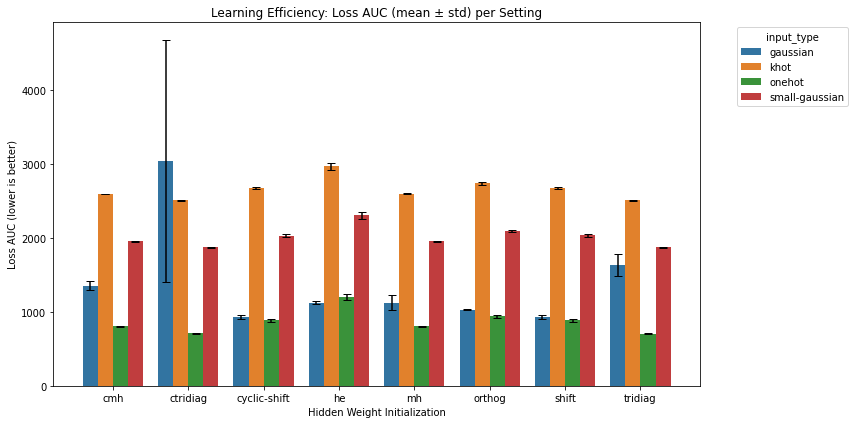

In [22]:
# 4) Barplot with error bars (loss AUC)
pm.plot_loss_auc_bar_with_std(agg_csv=agg_csv)

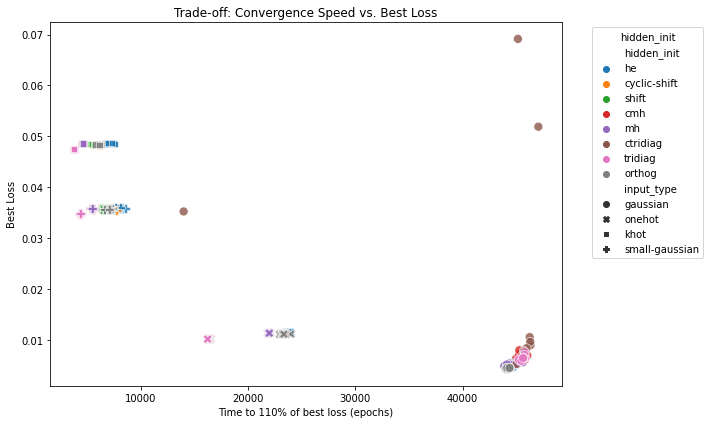

In [23]:
# 5) Scatter: speed vs performance
pm.plot_speed_vs_best_scatter(per_run_csv=per_run_csv)

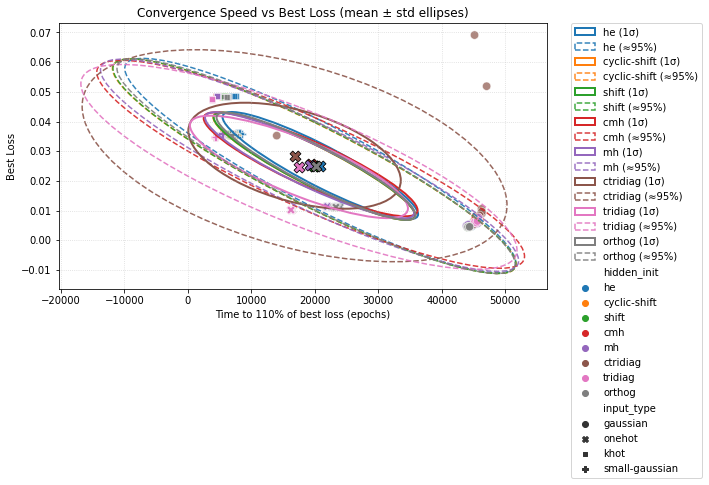

In [24]:
# 6) Scatter + ellipses
pm.plot_speed_vs_best_scatter_with_ellipses(per_run_csv=per_run_csv)